In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA not available, training on CPU ... ")
else:
    print("CUDA is available! training on GPU ... ")

CUDA is available! training on GPU ... 


In [0]:
import os

# define training and test data directories
data_dir = 'fruits-360_dataset/fruits-360/'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Test')

In [52]:
data_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print("Number of training images: ", len(train_data))
print("Number of test images: ", len(test_data))

Number of training images:  60498
Number of test images:  20622


In [0]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    idx_to_class = {i: classes[i] for i in range(len(classes))}
    return classes, class_to_idx, idx_to_class

In [0]:
batch_size = 64

# prepare the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=True)

In [55]:
class_names, class_idx, idx_class = find_classes(train_dir)
print(class_names)
len(class_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Eggplant', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut

120

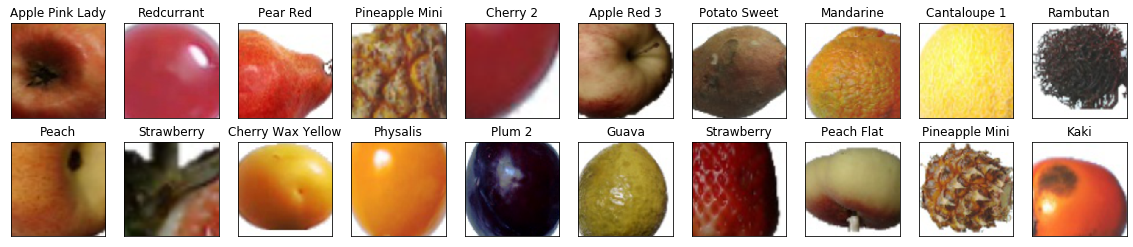

In [56]:
# Visualize some data
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy to display

images = images/2 + 0.5 # un-normalizing the images
# plot the figure
fig = plt.figure(figsize=(20,4))

for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1,2,0)))
    # ax.set_title(class_names[labels[idx]])
    ax.set_title(idx_class[int(labels[idx])])
plt.show()

In [57]:
# define the pretrained model from pytorch
model = models.densenet169(pretrained=True)

# print out the model structure
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [58]:
print(model.classifier.in_features)
print(model.classifier.out_features)

1664
1000


In [0]:
for param in model.features.parameters():
    param.requires_grad = False

In [0]:
# changing the classifier range according to the number of classes we have
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                                        ('fc1', nn.Linear(1664, 500)),
                                        ('relu', nn.ReLU()),
                                        ('fc2', nn.Linear(500, 120))
                                        ]))
model.classifier = classifier

In [0]:
# move the model to gpu, if available
if train_on_gpu:
    model.cuda()

In [0]:
# Specifying loss function and optimizer
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer, only training the last (classifier layer)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

In [63]:
# Training
# number of epochs to train the model
n_epochs = 50
test_loss_min = np.Inf  # track changes in test loss
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time
for epoch in range(n_epochs):
    train_loss = 0
    test_loss = 0
    
    train_acc = 0.0
    test_acc = 0.0
    
    # training mode
    model.train()
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        # clearing the optimizer
        optimizer.zero_grad()
        
        # Feed forward
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # backprop
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        # update the loss
        train_loss += loss.item()
        
        # calculate the class with max probability
        max_idx = torch.argmax(outputs, dim=1)
        corrects = (max_idx == labels.data).float().sum()
        train_acc += corrects / images.shape[0]
        
#     # evaluation mode
    model.eval()
    for images, labels in test_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        # Feed forward
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # update the loss
        test_loss += loss.item()
        
        # calculate the class with maximum probability
        max_idx = torch.argmax(outputs, dim=1)
        corrects = (max_idx == labels.data).float().sum()
        test_acc += corrects / images.shape[0]
        
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_acc = 100 * (train_acc / len(train_loader))
    test_acc = 100 * (test_acc / len(test_loader))
    print("Epoch: {} \t Training loss: {:.6f} \t Test loss: {:.6f}".format(
        epoch+1, train_loss, test_loss))
    print("Train accuracy: {:.3f} \t Test accuracy: {:.3f}".format(
        train_acc, test_acc))
    if test_loss <= test_loss_min:
        print("Test loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
            test_loss_min, test_loss))
        torch.save(model.state_dict(), 'fruits.pt')
        test_loss_min = test_loss

Epoch: 1 	 Training loss: 3.528312 	 Test loss: 2.062145
Train accuracy: 36.776 	 Test accuracy: 68.946
Test loss decreased (inf --> 2.062145). Saving model ... 
Epoch: 2 	 Training loss: 1.340013 	 Test loss: 0.964717
Train accuracy: 80.572 	 Test accuracy: 81.285
Test loss decreased (2.062145 --> 0.964717). Saving model ... 
Epoch: 3 	 Training loss: 0.749485 	 Test loss: 0.677745
Train accuracy: 86.624 	 Test accuracy: 85.567
Test loss decreased (0.964717 --> 0.677745). Saving model ... 
Epoch: 4 	 Training loss: 0.544334 	 Test loss: 0.535859
Train accuracy: 89.148 	 Test accuracy: 87.962
Test loss decreased (0.677745 --> 0.535859). Saving model ... 
Epoch: 5 	 Training loss: 0.436470 	 Test loss: 0.449465
Train accuracy: 90.938 	 Test accuracy: 89.635
Test loss decreased (0.535859 --> 0.449465). Saving model ... 
Epoch: 6 	 Training loss: 0.379070 	 Test loss: 0.396974
Train accuracy: 91.793 	 Test accuracy: 90.808
Test loss decreased (0.449465 --> 0.396974). Saving model ... 
Epo